## Big Data Individual assignment: Predicting Accident Severity using Machine Learning
 

### Student no-810259

## Table of Contents

1. Business Objective and problem context
2. Data load and selection
3. Data cleaning and transformation
4. Model Building
5. Hyperparameter tuning of the Models
6. Conclusion and result

Now a days Insurance companies are using data-driven decisions and  machine learning models to optimise all business areas to increase their profit. Claim payments are major cost and unpaid claims are largest liabilities.To optimise the process and increase their profit margin by setteling the proper insurance premium amount by assesing the risk profile of insurence claimer.  Informations relating to car, Driver, Driver area, Journey purpose of driver, vehicle conditins help to identify the risk associated with insuring the  particular driver or car. By proper analysing the data they can predict likelihood of accidents and severity.

As the severity of accident is categorical variable, the problem is classification type and there are three levels of accident severity thet the insurance company want to predict. As a business analyst team, we will handle this problem as a multiclass classification problem. Here we will find possible predictors to predict the classification target(accident severity).

In [43]:
#Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import time
import timeit
# execution time
from timeit import default_timer as timer
from datetime import timedelta



import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import math
from collections import Counter

#scipy
import scipy.stats as stats
from scipy import stats
from scipy.stats import chi2_contingency

# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#sklearn
import sklearn
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, log_loss, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.utils import resample


import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE

## 1.0 Business objective & Problem Context

Now a days Insurance companies are using data-driven decisions and  machine learning models to optimise all business areas to increase their profit. Claim payments are major cost and unpaid claims are largest liabilities.To optimise the process and increase their profit margin by setteling the proper insurance premium amount by assesing the risk profile of insurence claimer.  Informations relating to car, Driver, Driver area, Journey purpose of driver, vehicle conditins help to identify the risk associated with insuring the  particular driver or car. By proper analysing the data they can predict likelihood of accidents and severity.

As the severity of accident is categorical variable, the problem is classification type and there are three levels of accident severity thet the insurance company want to predict. As a business analyst team, we will handle this problem as a multiclass classification problem. Here we will find possible predictors to predict the classification target(accident severity).

## 2.0 Data Load and Feature Selection

### 2.1 Data Loading

In [44]:
#import files
trainset_final=pd.read_excel("trainset_final.xlsx")
testset_final=pd.read_excel("testset_final.xlsx")


### 2.2 Data Selection

In [97]:
#Cramer's V python function
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [98]:
# Remove outliers from each numerical column
for column in trainset_final.select_dtypes(include=['int', 'object']):
    if column != 'accident_severity':
        association_value = cramers_v(trainset_final['accident_severity'], trainset_final[column])
        print(f"The association between Accident_Severity column and {column} is: {association_value}")


The association between Accident_Severity column and accident_index is: 0.4134017163191814
The association between Accident_Severity column and vehicle_reference is: 0.0
The association between Accident_Severity column and vehicle_type is: 0.0833597241473991
The association between Accident_Severity column and towing_and_articulation is: 0.018234214221721515
The association between Accident_Severity column and vehicle_left_hand_drive is: 0.0
The association between Accident_Severity column and journey_purpose_of_driver is: 0.06365335322957162
The association between Accident_Severity column and sex_of_driver is: 0.01872235035784986
The association between Accident_Severity column and age_of_driver is: 0.06663573062881759
The association between Accident_Severity column and engine_capacity_cc is: 0.20077191140262338
The association between Accident_Severity column and propulsion_code is: 0.0
The association between Accident_Severity column and age_of_vehicle is: 0.025219156866305756
The

### Interpretation of Phi and Cramer's V.

Phi and Cramer's V	Interpretation
- 0.25	Very strong
- 0.15	Strong
- 0.10	Moderate
- 0.05	Weak
- 0	No or very weak

Reference of this table: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6107969/

As per Cramers'V interpretion, vehicle_left_hand_drive has no association to accident severity. Additionally, Accident_Index and Vehicle reference columns were only needed to join Collision and Vehicle dataset. These 3 columns are not going to be useful for predicting Accident severity. Hence, I am dropping these 3 columns from the DataFrame.


In [45]:
#Delete 3 columns from training set
df_trainset = trainset_final.drop(columns=['accident_index','vehicle_reference','vehicle_left_hand_drive'])

df_trainset.head()

,accident_severity,vehicle_type,towing_and_articulation,journey_purpose_of_driver,sex_of_driver,age_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_home_area_type,driver_imd_decile
0,2,9,0,2,1,42,1686,2,12,1,1
1,3,3,0,1,1,34,108,1,7,1,3
2,3,9,0,2,2,33,999,1,9,1,5
3,2,21,0,1,1,50,12742,2,1,1,8
4,3,3,0,1,1,19,110,1,1,1,8


In [46]:
#Delete 3 columns from the test set
df_testset = testset_final.drop(columns=['accident_index','vehicle_reference','vehicle_left_hand_drive'])

df_testset.columns

Index(['accident_severity', 'vehicle_type', 'towing_and_articulation',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'engine_capacity_cc', 'propulsion_code', 'age_of_vehicle',
       'driver_home_area_type', 'driver_imd_decile'],
      dtype='object')

#### Categorical variables encoding

In [47]:
 # Convert numerical categories to strings for training data
features_df_train = df_trainset.astype(str)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')
cat_coloumns=['vehicle_type','towing_and_articulation', 'journey_purpose_of_driver', 'sex_of_driver','propulsion_code','driver_home_area_type','driver_imd_decile']
cat_vals=features_df_train[cat_coloumns]
transformed = encoder.fit_transform(cat_vals)
transformed

C:\Users\Joydeep\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [48]:
# the names of the new columns
new_col_names = encoder.get_feature_names_out(cat_coloumns)

new_col_names

array(['vehicle_type_11', 'vehicle_type_17', 'vehicle_type_19',
       'vehicle_type_2', 'vehicle_type_20', 'vehicle_type_21',
       'vehicle_type_3', 'vehicle_type_4', 'vehicle_type_5',
       'vehicle_type_8', 'vehicle_type_9', 'vehicle_type_90',
       'towing_and_articulation_1', 'towing_and_articulation_2',
       'towing_and_articulation_3', 'towing_and_articulation_4',
       'towing_and_articulation_5', 'towing_and_articulation_9',
       'journey_purpose_of_driver_2', 'journey_purpose_of_driver_3',
       'journey_purpose_of_driver_4', 'journey_purpose_of_driver_5',
       'sex_of_driver_2', 'sex_of_driver_3', 'propulsion_code_12',
       'propulsion_code_2', 'propulsion_code_5', 'propulsion_code_7',
       'propulsion_code_8', 'driver_home_area_type_2',
       'driver_home_area_type_3', 'driver_imd_decile_10',
       'driver_imd_decile_2', 'driver_imd_decile_3',
       'driver_imd_decile_4', 'driver_imd_decile_5',
       'driver_imd_decile_6', 'driver_imd_decile_7',
       '

In [49]:
for i,new_col_name in enumerate(new_col_names):
# # put the transformed data as columns in the trainset dataframe
   features_df_train[new_col_name] = transformed[:,i]
    
features_df_train.shape

(8072, 51)

In [50]:
# delete the original categorical columns
features_df_train = features_df_train.drop(cat_coloumns, axis=1)

In [51]:
features_df_train.columns

Index(['accident_severity', 'age_of_driver', 'engine_capacity_cc',
       'age_of_vehicle', 'vehicle_type_11', 'vehicle_type_17',
       'vehicle_type_19', 'vehicle_type_2', 'vehicle_type_20',
       'vehicle_type_21', 'vehicle_type_3', 'vehicle_type_4', 'vehicle_type_5',
       'vehicle_type_8', 'vehicle_type_9', 'vehicle_type_90',
       'towing_and_articulation_1', 'towing_and_articulation_2',
       'towing_and_articulation_3', 'towing_and_articulation_4',
       'towing_and_articulation_5', 'towing_and_articulation_9',
       'journey_purpose_of_driver_2', 'journey_purpose_of_driver_3',
       'journey_purpose_of_driver_4', 'journey_purpose_of_driver_5',
       'sex_of_driver_2', 'sex_of_driver_3', 'propulsion_code_12',
       'propulsion_code_2', 'propulsion_code_5', 'propulsion_code_7',
       'propulsion_code_8', 'driver_home_area_type_2',
       'driver_home_area_type_3', 'driver_imd_decile_10',
       'driver_imd_decile_2', 'driver_imd_decile_3', 'driver_imd_decile_4',
      

In testset, there is no data for propulsion_code =5 which is why after encoding, propulsion_code_5 column is not being created. Without train set and test set columns matching, subsequenty during the machine learning baseline, following error was occuring: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- propulsion_code_5

Upon checking the value count in train dataset, I noticed only 4 records with propulsion code as 5. Hence I dropped the column from train set as well.

In [52]:
#features_df_train_drop=features_df_train.drop(columns=['propulsion_code_5'])
features_df_train_drop=features_df_train.drop(columns=['towing_and_articulation_2','propulsion_code_5'])
features_df_train_drop

,accident_severity,age_of_driver,engine_capacity_cc,age_of_vehicle,vehicle_type_11,vehicle_type_17,vehicle_type_19,vehicle_type_2,vehicle_type_20,vehicle_type_21,...,driver_home_area_type_3,driver_imd_decile_10,driver_imd_decile_2,driver_imd_decile_3,driver_imd_decile_4,driver_imd_decile_5,driver_imd_decile_6,driver_imd_decile_7,driver_imd_decile_8,driver_imd_decile_9
0,2,42,1686,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,34,108,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,33,999,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,50,12742,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,19,110,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8067,3,59,1198,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8068,3,42,1499,7,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8069,2,27,1798,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8070,3,57,1995,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
features_df_train_drop.shape

(8072, 42)

In [54]:
# Convert numerical categories to strings for test data
features_df_test = df_testset.astype(str)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')
cat_coloumns=['vehicle_type','towing_and_articulation', 'journey_purpose_of_driver', 'sex_of_driver','propulsion_code','driver_home_area_type','driver_imd_decile']
cat_vals=features_df_test[cat_coloumns]
transformed = encoder.fit_transform(cat_vals)
transformed

C:\Users\Joydeep\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
# the names of the new columns
new_col_names = encoder.get_feature_names_out(cat_coloumns)

new_col_names
for i,new_col_name in enumerate(new_col_names):
# # put the transformed data as columns in the trainset dataframe
   features_df_test[new_col_name] = transformed[:,i]
    
features_df_test.columns

Index(['accident_severity', 'vehicle_type', 'towing_and_articulation',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'engine_capacity_cc', 'propulsion_code', 'age_of_vehicle',
       'driver_home_area_type', 'driver_imd_decile', 'vehicle_type_11',
       'vehicle_type_17', 'vehicle_type_19', 'vehicle_type_2',
       'vehicle_type_20', 'vehicle_type_21', 'vehicle_type_3',
       'vehicle_type_4', 'vehicle_type_5', 'vehicle_type_8', 'vehicle_type_9',
       'vehicle_type_90', 'towing_and_articulation_1',
       'towing_and_articulation_3', 'towing_and_articulation_4',
       'towing_and_articulation_5', 'towing_and_articulation_9',
       'journey_purpose_of_driver_2', 'journey_purpose_of_driver_3',
       'journey_purpose_of_driver_4', 'journey_purpose_of_driver_5',
       'sex_of_driver_2', 'sex_of_driver_3', 'propulsion_code_12',
       'propulsion_code_2', 'propulsion_code_7', 'propulsion_code_8',
       'driver_home_area_type_2', 'driver_home_area_type

In [56]:
# delete the original categorical columns
features_df_test = features_df_test.drop(cat_coloumns, axis=1)

In [57]:
# separate the target and predictors
ytrain = features_df_train_drop["accident_severity"].copy()
Xtrain = features_df_train_drop.drop("accident_severity", axis=1)
ytest = features_df_test["accident_severity"].copy()
Xtest = features_df_test.drop("accident_severity", axis=1)

In [58]:
Xtrain.shape

(8072, 41)

In [59]:
Xtest.shape

(2014, 41)

In [60]:
Xtrain.columns  ##  towing_and_articulation_2 & propulsion code 5

Index(['age_of_driver', 'engine_capacity_cc', 'age_of_vehicle',
       'vehicle_type_11', 'vehicle_type_17', 'vehicle_type_19',
       'vehicle_type_2', 'vehicle_type_20', 'vehicle_type_21',
       'vehicle_type_3', 'vehicle_type_4', 'vehicle_type_5', 'vehicle_type_8',
       'vehicle_type_9', 'vehicle_type_90', 'towing_and_articulation_1',
       'towing_and_articulation_3', 'towing_and_articulation_4',
       'towing_and_articulation_5', 'towing_and_articulation_9',
       'journey_purpose_of_driver_2', 'journey_purpose_of_driver_3',
       'journey_purpose_of_driver_4', 'journey_purpose_of_driver_5',
       'sex_of_driver_2', 'sex_of_driver_3', 'propulsion_code_12',
       'propulsion_code_2', 'propulsion_code_7', 'propulsion_code_8',
       'driver_home_area_type_2', 'driver_home_area_type_3',
       'driver_imd_decile_10', 'driver_imd_decile_2', 'driver_imd_decile_3',
       'driver_imd_decile_4', 'driver_imd_decile_5', 'driver_imd_decile_6',
       'driver_imd_decile_7', 'driver_

In [61]:
Xtest.columns 

Index(['age_of_driver', 'engine_capacity_cc', 'age_of_vehicle',
       'vehicle_type_11', 'vehicle_type_17', 'vehicle_type_19',
       'vehicle_type_2', 'vehicle_type_20', 'vehicle_type_21',
       'vehicle_type_3', 'vehicle_type_4', 'vehicle_type_5', 'vehicle_type_8',
       'vehicle_type_9', 'vehicle_type_90', 'towing_and_articulation_1',
       'towing_and_articulation_3', 'towing_and_articulation_4',
       'towing_and_articulation_5', 'towing_and_articulation_9',
       'journey_purpose_of_driver_2', 'journey_purpose_of_driver_3',
       'journey_purpose_of_driver_4', 'journey_purpose_of_driver_5',
       'sex_of_driver_2', 'sex_of_driver_3', 'propulsion_code_12',
       'propulsion_code_2', 'propulsion_code_7', 'propulsion_code_8',
       'driver_home_area_type_2', 'driver_home_area_type_3',
       'driver_imd_decile_10', 'driver_imd_decile_2', 'driver_imd_decile_3',
       'driver_imd_decile_4', 'driver_imd_decile_5', 'driver_imd_decile_6',
       'driver_imd_decile_7', 'driver_

In [62]:
severity_mapping = {'Fatal':1, 'Serious':2, 'Slight':3}
#Target variable Accident_Severity descriptions are reverted to the corresponding codes
ytrain = ytrain.replace(severity_mapping)
ytest = ytest.replace(severity_mapping)

### 2.3 Imbalance Dataset Handling

During EDA, it was noticed that the accident dataset is highly imbalanced with respective to accident_severity class labels. Majority class in this dataset is slight and rest of the classes are minority classes. 

With such imbalance in the dataset, there is a possibility that the classification problem will be overfitted to the majority class and minority classes will be ignored. 

To overcome the problem, I have noticed that there are following ways to treat the data imbalance.
- Random Oversampling
- Random Undersampling
- Synthetic data creation of the minority classes

For this dataset, I am proceeding with technique called **SMOTE** which is oversampling technique to generate synthetic data of the minority classes. 


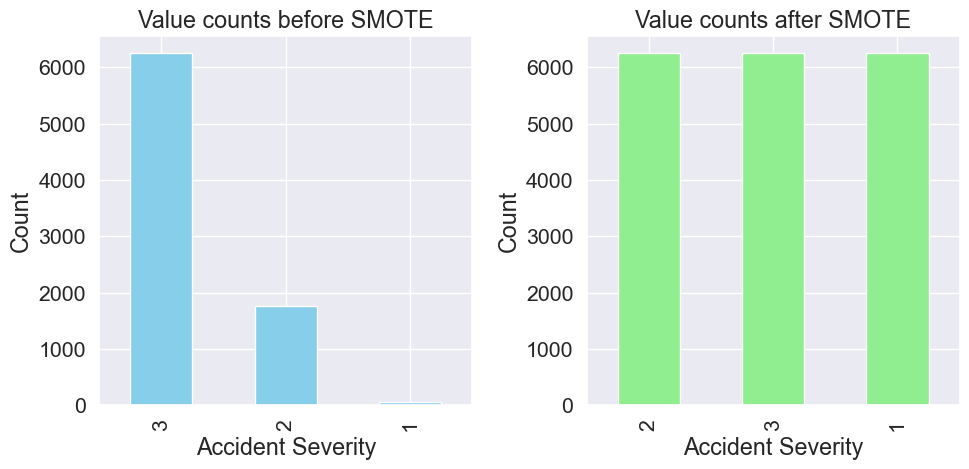

In [63]:
def apply_smote(X_train, y_train):
    # Display value counts before SMOTE
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    y_train.value_counts().plot(kind='bar', color='skyblue')
    plt.title("Value counts before SMOTE")
    plt.xlabel("Accident Severity")
    plt.ylabel("Count")

    # Apply SMOTE
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Convert y_train_resampled to a dataframe
    y_train_resampled = pd.DataFrame(y_train_resampled, columns=[y_train.name])

    # Display value counts after SMOTE
    plt.subplot(1, 2, 2)
    y_train_resampled[y_train.name].value_counts().plot(kind='bar', color='lightgreen')
    plt.title("Value counts after SMOTE")
    plt.xlabel("Accident Severity")
    plt.ylabel("Count")
    
    plt.tight_layout()
    plt.show()

    return X_train_resampled, y_train_resampled

# Calling the function on the train data:

X_train_resampled, y_train_resampled = apply_smote(Xtrain, ytrain)

In [64]:
columns_to_convert = ['age_of_driver','engine_capacity_cc','age_of_vehicle']

# Convert each column back to numeric type
for col in columns_to_convert:
    X_train_resampled[col] = pd.to_numeric(X_train_resampled[col], errors='coerce')

# Check the data types after conversion
print(X_train_resampled.dtypes)

age_of_driver                  float64
engine_capacity_cc             float64
age_of_vehicle                 float64
vehicle_type_11                float64
vehicle_type_17                float64
vehicle_type_19                float64
vehicle_type_2                 float64
vehicle_type_20                float64
vehicle_type_21                float64
vehicle_type_3                 float64
vehicle_type_4                 float64
vehicle_type_5                 float64
vehicle_type_8                 float64
vehicle_type_9                 float64
vehicle_type_90                float64
towing_and_articulation_1      float64
towing_and_articulation_3      float64
towing_and_articulation_4      float64
towing_and_articulation_5      float64
towing_and_articulation_9      float64
journey_purpose_of_driver_2    float64
journey_purpose_of_driver_3    float64
journey_purpose_of_driver_4    float64
journey_purpose_of_driver_5    float64
sex_of_driver_2                float64
sex_of_driver_3          

In [65]:
y_train_resampled

,accident_severity
0,2
1,3
2,3
3,2
4,3
...,...
18739,2
18740,2
18741,2
18742,2


In [66]:
Xtest.dtypes

age_of_driver                   object
engine_capacity_cc              object
age_of_vehicle                  object
vehicle_type_11                float64
vehicle_type_17                float64
vehicle_type_19                float64
vehicle_type_2                 float64
vehicle_type_20                float64
vehicle_type_21                float64
vehicle_type_3                 float64
vehicle_type_4                 float64
vehicle_type_5                 float64
vehicle_type_8                 float64
vehicle_type_9                 float64
vehicle_type_90                float64
towing_and_articulation_1      float64
towing_and_articulation_3      float64
towing_and_articulation_4      float64
towing_and_articulation_5      float64
towing_and_articulation_9      float64
journey_purpose_of_driver_2    float64
journey_purpose_of_driver_3    float64
journey_purpose_of_driver_4    float64
journey_purpose_of_driver_5    float64
sex_of_driver_2                float64
sex_of_driver_3          

In [67]:
columns_to_convert = ['age_of_driver','engine_capacity_cc','age_of_vehicle']

# Convert each column back to numeric type
for col in columns_to_convert:
    Xtest[col] = pd.to_numeric(Xtest[col], errors='coerce')

# Check the data types after conversion
print(Xtest.dtypes)

age_of_driver                    int64
engine_capacity_cc               int64
age_of_vehicle                   int64
vehicle_type_11                float64
vehicle_type_17                float64
vehicle_type_19                float64
vehicle_type_2                 float64
vehicle_type_20                float64
vehicle_type_21                float64
vehicle_type_3                 float64
vehicle_type_4                 float64
vehicle_type_5                 float64
vehicle_type_8                 float64
vehicle_type_9                 float64
vehicle_type_90                float64
towing_and_articulation_1      float64
towing_and_articulation_3      float64
towing_and_articulation_4      float64
towing_and_articulation_5      float64
towing_and_articulation_9      float64
journey_purpose_of_driver_2    float64
journey_purpose_of_driver_3    float64
journey_purpose_of_driver_4    float64
journey_purpose_of_driver_5    float64
sex_of_driver_2                float64
sex_of_driver_3          

In [68]:
X_train_resampled.dtypes

age_of_driver                  float64
engine_capacity_cc             float64
age_of_vehicle                 float64
vehicle_type_11                float64
vehicle_type_17                float64
vehicle_type_19                float64
vehicle_type_2                 float64
vehicle_type_20                float64
vehicle_type_21                float64
vehicle_type_3                 float64
vehicle_type_4                 float64
vehicle_type_5                 float64
vehicle_type_8                 float64
vehicle_type_9                 float64
vehicle_type_90                float64
towing_and_articulation_1      float64
towing_and_articulation_3      float64
towing_and_articulation_4      float64
towing_and_articulation_5      float64
towing_and_articulation_9      float64
journey_purpose_of_driver_2    float64
journey_purpose_of_driver_3    float64
journey_purpose_of_driver_4    float64
journey_purpose_of_driver_5    float64
sex_of_driver_2                float64
sex_of_driver_3          

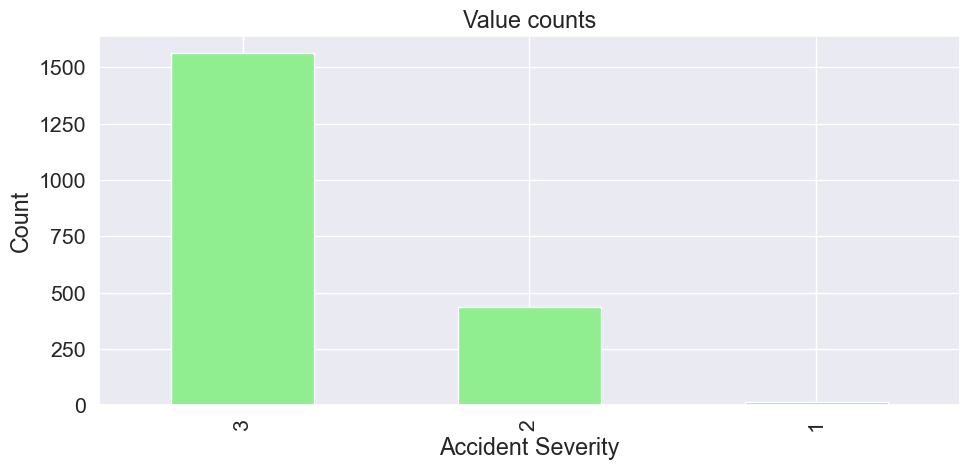

In [69]:
plt.figure(figsize=(10, 5))
ytest.value_counts().plot(kind='bar', color='lightgreen')
plt.title("Value counts")
plt.xlabel("Accident Severity")
plt.ylabel("Count")
  
plt.tight_layout()
plt.show()

In [70]:
#Applying level encoder on the predictor value 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled)
y_test_new=le.fit_transform(ytest)


In [71]:
 #Computation of confusion matrix to visualise the model predictions against the actual labels
def conf_mat(y_pred, ytest):
    class_names = ['Fatal', 'Serious', 'Slight']
    tick_marks_y = [0.5, 1.5, 2.5]
    tick_marks_x = [0.5, 1.5, 2.5]
    confusion_matrix = metrics.confusion_matrix(ytest, y_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(3), range(3))
    plt.figure(figsize = (6, 4.75))
    sns.set(font_scale = 1.4) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": 16}, fmt = 'd',cmap='seismic')
 # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

## 4.0 Model Building

In this section, I will build approriate machine learning models which will predict the multi-class classifiers. For predicting multi-class classifiers, I have picked up the 5 algorithms commonly used. 

1. Decision Tree
2. RandomForest Classifier
3. XGBoost Classifier
4. Support Vector Machine
5. ADABoost

To evaluate the performance of the models, I am going to use following metrics along with their processing time- 

- Precision
- Recall
- F1 Score


### 4.1 Base Models Building

#### 4.1.1 Dummy Classifier

In [72]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_resampled, y_train_resampled)
y_predict = dummy_clf.predict(X_train_resampled)

p, r, f, s = precision_recall_fscore_support(y_train_resampled, y_predict, average="weighted", zero_division=0.0)
print(f"Baseline:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")

Baseline:
Precision: 0.111
Recall: 0.333
F score: 0.167


In [73]:
#Empty dictionary to hold all the base model performances
f1_score_comparator = []

#### 4.1.2 DecisionTreeClassifier - Base Model

Execution time of Decision Tree is: 0.352 seconds
Precision: 0.651
Recall: 0.634
F score: 0.642


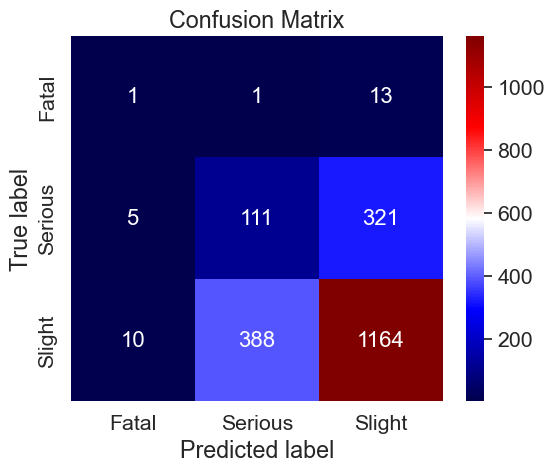

In [74]:
#DecisionTreeClassifier

start = time.time()#Captured the start time of the code block

#Initialise DecisionTree Classifier
dt = DecisionTreeClassifier(random_state = 42)

#Applying DecisionTree classifier to fit the model to our trainset data
dt.fit(X_train_resampled, y_train_encoded)

#Predicting Accident_Severity from the test dataset
y_pred = dt.predict(Xtest)
p, r, f_dt, s= precision_recall_fscore_support(y_test_new, y_pred, average = 'weighted',zero_division=0.0)
dec_tree_duration = time.time()-start

print(f'Execution time of Decision Tree is: {dec_tree_duration:.3f} seconds')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f_dt:.3f}")
f1_score_comparator.append(['Decision Tree', dec_tree_duration, f_dt])
conf_mat(y_pred, y_test_new)

#### 4.1.3 RandomForestClassifier - Base Model

Execution time of Random Forest Model is: 5.185 seconds
Precision: 0.642
Recall: 0.730
F score: 0.674


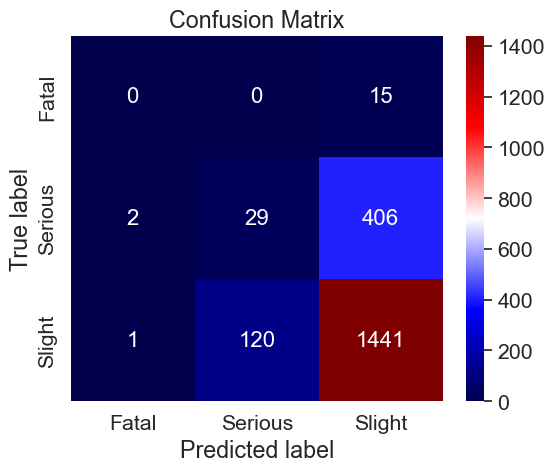

In [75]:
start = time.time()
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_resampled, y_train_encoded)
y_pred = rf.predict(Xtest)
p, r, f_ran, s= precision_recall_fscore_support(y_test_new, y_pred, average = 'weighted')

randomforest_duration = time.time()-start
print(f'Execution time of Random Forest Model is: {randomforest_duration:.3f} seconds')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f_ran:.3f}")
f1_score_comparator.append(['Random Forest', randomforest_duration, f_ran])
conf_mat(y_pred, y_test_new)


#### 4.1.4 XGBoost model - Base Model

Execution time of XGBoost Model is: 1.332 seconds
Precision: 0.661
Recall: 0.758
F score: 0.685


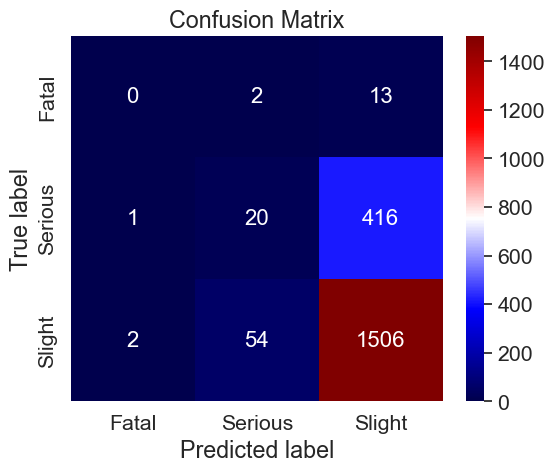

In [76]:
start = time.time()
#class_weights = {0: 12, 1: 6, 2: 1}
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train_resampled, y_train_encoded)
y_pred_xgb = xgb.predict(Xtest)
p, r, f_xgb, s= precision_recall_fscore_support(y_test_new, y_pred_xgb, average = 'weighted')
XGBoost_duration = time.time()-start
print(f'Execution time of XGBoost Model is: {XGBoost_duration:.3f} seconds')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f_xgb:.3f}")
f1_score_comparator.append(['XGBoost', XGBoost_duration, f_xgb])
conf_mat(y_pred_xgb, y_test_new)


#### 4.1.5 SVM model - Base Model

Execution time of SVM Model is: 28.734 seconds
Precision: 0.675
Recall: 0.284
F score: 0.253


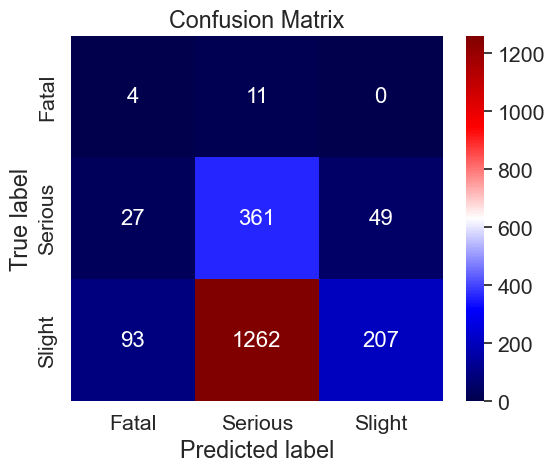

In [77]:
# Initialize SVM classifier
start = time.time()
svm_classifier = SVC()

# Fit the classifier to the training data
svm_classifier.fit(X_train_resampled, y_train_encoded)

# Predict on the testing data
y_pred = svm_classifier.predict(Xtest)

p, r, f, s= precision_recall_fscore_support(y_test_new, y_pred, average = 'weighted')
SVM_duration = time.time()-start
print(f'Execution time of SVM Model is: {SVM_duration:.3f} seconds')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
f1_score_comparator.append(['SVM', SVM_duration, f])
conf_mat(y_pred, y_test_new)


#### 4.1.6 AdaBoost - Base Model

Execution time of AdaBoost Model is: 1.679 seconds
Precision: 0.666
Recall: 0.689
F score: 0.676


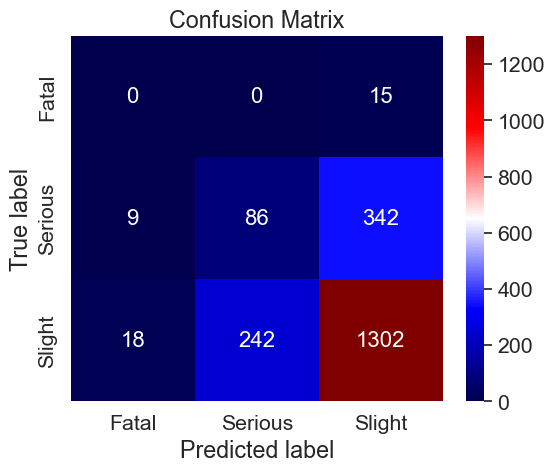

In [78]:
start = time.time()
# Create AdaBoost classifier
adaboost_clf = AdaBoostClassifier()

# Train the classifier
adaboost_clf.fit(X_train_resampled, y_train_encoded)

# Predict on the test set
y_pred = adaboost_clf.predict(Xtest)

p, r, f_ada, s= precision_recall_fscore_support(y_test_new, y_pred, average = 'weighted')
Adaboost_duration = time.time()-start
print(f'Execution time of AdaBoost Model is: {Adaboost_duration:.3f} seconds')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f_ada:.3f}")
f1_score_comparator.append(['AdaBoost', Adaboost_duration, f_ada])
conf_mat(y_pred, y_test_new)

### 4.2 Base models Comparison

In [79]:
f1_df = pd.DataFrame(f1_score_comparator, columns=['Classifier', 'Execution Time', 'F1-Score']) #Copying the value into f1_df in a pandas dataframe format along with the column names
f1_df.sort_values(by = 'F1-Score', ascending = False, inplace=True)#Sorting the dataframe by F1-Score column
f1_df

,Classifier,Execution Time,F1-Score
2,XGBoost,1.332211,0.684925
4,AdaBoost,1.679037,0.675791
1,Random Forest,5.185351,0.674278
0,Decision Tree,0.352059,0.641931
3,SVM,28.734277,0.252689


SVM model has the highest execution time and lowest F1-Score. Based on this metrics, I am not progressing with SVM model analysis any further for this dataset.

The top 3 models according to F1-Score is XGBoost,Random Forest and ADABoost. Random Forest model execution time is higher in comparison to XGBoost and ADABoost. Since Decision Tree model execution time is fastest and as per the base model, F1-score is also close enough, I have decided to choose all 4 models for hyperparameter tuning except SVM

##  5.0 Hyperparameter Tuning

In [165]:
#Initialising an empty list to store the F1-scores of each model after hyperparameter tuning
hpt_score_comparator = []

### 5.1 DecisionTree Hyperparameter Tuning

For improving the performance of the Decision Tree, I am using GridSearchCV method which will systematically search through the best parameter from the given set of parameters. This is a cross-validation technique where I am using 5-fold cross validation.


In [166]:
#Now I'll apply hyperparameter tuning in Decision Tree model
from sklearn.model_selection import GridSearchCV
start = time.time()

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=7)

hp_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35],
}

grid_search = GridSearchCV(dt, hp_grid, cv=5,
                           scoring='f1_weighted', 
                           return_train_score=True, verbose=2)

grid_search.fit(X_train_resampled, y_train_encoded)
DT_HP_duration = time.time()-start
print(f'Execution time of Decision Tree Hyperparameter Model is: {DT_HP_duration:.3f} seconds')

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.1s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.1s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.3s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.3s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.2s
[CV] END ..................max_depth=5, min_sam

In [167]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=20, min_samples_split=30, random_state=7)

Best Estimator: DecisionTreeClassifier(max_depth=20, min_samples_split=30, random_state=7)

As per the GridSearch parameters, the decision tree providing best prediction for this data has following configuration -

**Maximum depth** is 20. This signifies a moderately deep tree with complex splits. A deep tree has the potential of overfitting meaning that there is a potential that the model may start rememering the training data instead of learning patterns that can be generalized. 
**Min Samples Split** is 30 in this case. This signifies that node with less than 30 samples will be treated as leaf nodes. If at least 30 samples are present, this model can consider splitting the node.

Although I am training with ~19k training set records which should be large enough for the decision tree to have complex patterns to be fitted rather than overfitting from it. Hence, reviewing the average prediction score between training and test set.

In [168]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"])/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
26,"{'max_depth': 20, 'min_samples_split': 30}",0.888794,0.813236,8.501188
21,"{'max_depth': 20, 'min_samples_split': 5}",0.936093,0.812648,13.187299
33,"{'max_depth': 25, 'min_samples_split': 30}",0.896419,0.812142,9.401539
54,"{'max_depth': 40, 'min_samples_split': 30}",0.899894,0.812057,9.760843
47,"{'max_depth': 35, 'min_samples_split': 30}",0.899894,0.812057,9.760843
40,"{'max_depth': 30, 'min_samples_split': 30}",0.899380,0.811960,9.719966
28,"{'max_depth': 25, 'min_samples_split': 5}",0.957214,0.811098,15.264730
22,"{'max_depth': 20, 'min_samples_split': 10}",0.919594,0.810872,11.822882
32,"{'max_depth': 25, 'min_samples_split': 25}",0.902890,0.810635,10.217825
27,"{'max_depth': 20, 'min_samples_split': 35}",0.882774,0.810048,8.238335


**Interpretation of the result** The model with the specified hyperparameter {'max_depth': 20, 'min_samples_split': 30}	has yielded the best result on predicting the accident severity on the test data. For the best hyper-parameter model,the difference between trainset and testset is 8.50%. Hence, we can conclude that model has not overfitted which is why we can take this as best model for Decision Tree.


Precision: 0.647
Recall: 0.693
F score: 0.667


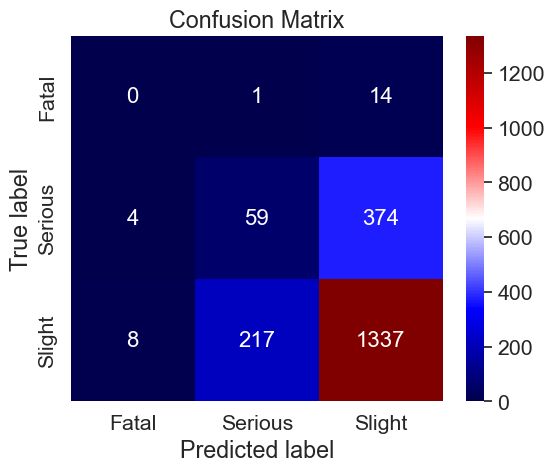

In [170]:
# I'll predict the result  on the testset by fitting test data on  best model estimater 
best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

p, r, f, s= precision_recall_fscore_support(y_test_new, yhat, average = 'weighted')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
hpt_score_comparator.append(['Decision Tree Hyperparameter Tuned',f, f_dt])
conf_mat(yhat, y_test_new)

###  5.2 Random Forest Hyperparameter tuning

In [176]:
# Randomly searching the best parameters (n_estimators  that is no of trees and features will be chosen randomly to ensure that the trees are not correlated) 
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
start=timer()
# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': randint(10, 100),  # Maximum number of levels in tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10)  # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize RandomizedSearchCV with the classifier and parameter grid
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=100, cv=5,scoring='f1_macro', random_state=42)
# Fit the RandomizedSearchCV object to your data
random_search.fit(X_train_resampled, y_train_encoded)

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

C:\Users\Joydeep\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
235 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
235 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Joydeep\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Joydeep\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Joydeep\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Joydeep\anaconda3\Lib\s

Best Parameters: {'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 615}
Best Score: 0.8700803358177932
Execution time HH:MM:SS: 3:33:11.288959


In [48]:
random_search.best_estimator_

RandomForestClassifier(max_depth=28, min_samples_split=6, n_estimators=615)

RandomForestClassifier(max_depth=28, min_samples_split=6, n_estimators=615)

Precision: 0.654
Recall: 0.755
F score: 0.682


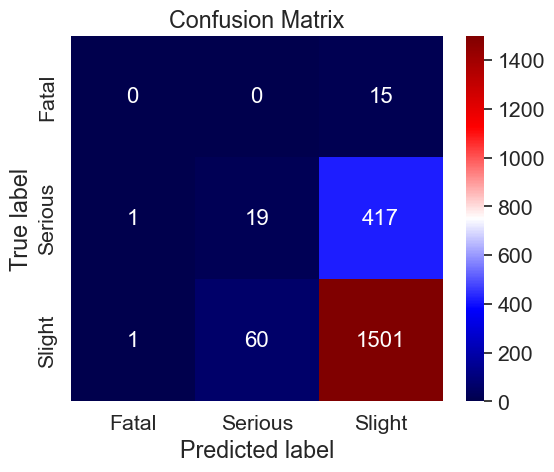

In [177]:
best_model_random = random_search.best_estimator_

yhat = best_model_random.predict(Xtest)

p, r, f, s= precision_recall_fscore_support(y_test_new, yhat, average = 'weighted')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
conf_mat(yhat, y_test_new)
hpt_score_comparator.append(['Random Forest Hyperparameter Tuned',f, f_ran])

###  5.3 ADABoost Hyperparameter tuning

In [171]:
start=timer()
# Define the AdaBoost classifier
adaboost = AdaBoostClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}
# Use GridSearchCV to search for the best hyperparameters
grid_searchADA = GridSearchCV(adaboost, param_grid, cv=5, scoring='f1_weighted', verbose=1)

grid_searchADA.fit(X_train_resampled, y_train_encoded)

# Get the best model
best_adaboost = grid_searchADA.best_estimator_
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Execution time HH:MM:SS: 0:18:08.943838


Precision: 0.677
Recall: 0.761
F score: 0.691


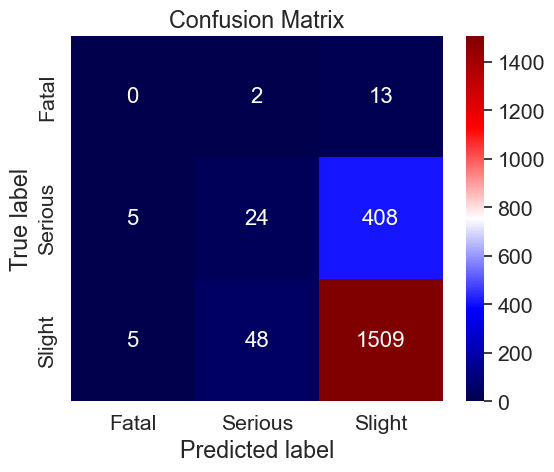

In [172]:
# Evaluate the best model on the test set
yhat_ada = best_adaboost.predict(Xtest)
p, r, f, s= precision_recall_fscore_support(y_test_new, yhat_ada, average = 'weighted')
#print('Execution time of ADaBoost Hyperparameter Model is:',timedelta(seconds=timer() - start))
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
conf_mat(yhat_ada, y_test_new)
hpt_score_comparator.append(['ADABoost Hyperparameter Tuned',f, f_ada])

### 5.4 XGBoost Hyperparameter tuning

In [173]:
# Hyperparameter tuning for XGBoost
start=timer()
xgb = XGBClassifier()
params_xgb = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 2, 5],
              'subsample': [0.6, 1.0],
              'colsample_bytree': [0.6],
              'max_depth': [4, 5],
              }
gsearch_xgb = GridSearchCV(estimator = xgb, param_grid = params_xgb, scoring = 'f1_weighted', n_jobs = -1, cv = 5, verbose = 3)
gsearch_xgb_fit = gsearch_xgb.fit(X = X_train_resampled, y = y_train_encoded)
print("Best parameters: {}".format(gsearch_xgb.best_params_))
print("Best weighted F1-score: {}".format(gsearch_xgb.best_score_))
print(" ")
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}
Best weighted F1-score: 0.855556120535843
 
Execution time HH:MM:SS: 0:01:45.373058


Precision: 0.668
Recall: 0.767
F score: 0.685


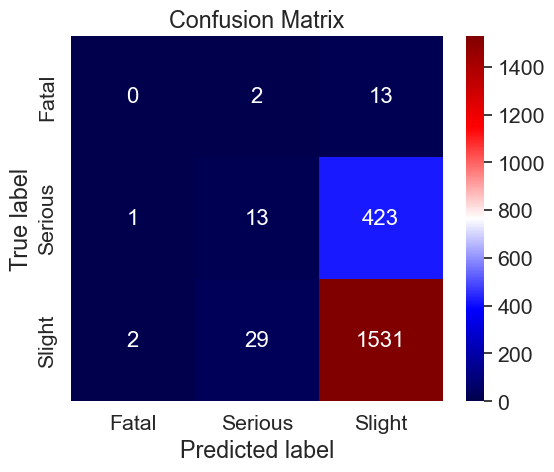

In [174]:
#evaluation on the test set
xgb_best = gsearch_xgb.best_estimator_
xgb_best.fit(X_train_resampled, y_train_encoded)
y_pred_xgb = xgb_best.predict(Xtest)

p, r, f, s= precision_recall_fscore_support(y_test_new, y_pred_xgb, average = 'weighted')
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
conf_mat(y_pred_xgb, y_test_new)
hpt_score_comparator.append(['XGBoost Hyperparameter Tuned',f, f_xgb])


### 5.5 Models Performance after Hyperparameter Tuning

In [178]:
f1_df_hpt = pd.DataFrame(hpt_score_comparator, columns=['Classifier', 'F1-Score post tuning', 'F1-Score Previous'])
f1_df_hpt.sort_values(by = 'F1-Score post tuning', ascending = False, inplace=True)
f1_df_hpt

,Classifier,F1-Score post tuning,F1-Score Previous
1,ADABoost Hyperparameter Tuned,0.690678,0.650034
2,XGBoost Hyperparameter Tuned,0.684667,0.687216
3,Random Forest Hyperparameter Tuned,0.682149,0.673890
0,Decision Tree Hyperparameter Tuned,0.666793,0.647839


Comparing the metrics before and after hyperparameter tuning, it is clear that all of the models have shown some improvement on the F1-score.
After hyperparameter tuning, ADABoost model is giving the best result among the models attempted.

ADABoost model's weighted F1 score is .690 which is an average score. 

The reported precision of 0.677 means that, on average, the model is correctly predicting the accident severity of 67.7% instances. The recall of 0.761 indicates that the model captures approximately 76.1% of all actual positive instances. The F1 score being the weighted average of precision and recall, giving a score of 0.691.
Model is predicting higher number of false positives which is reducing the precision score.

In [184]:
best_adaboost


AdaBoostClassifier(n_estimators=200)

In [188]:
import joblib
# save the model
joblib.dump(best_adaboost, 'adaboost_multiclassifier.joblib')

['adaboost_multiclassifier.joblib']

 As my dataset is highly  imbalance.I will assign some class weight according to severity in my best Adaboost model.

#### Hyperparameter using weights

In [179]:
weights = np.ones(len(y_train_encoded))
weights[y_train_encoded == 0] = 4  # Assign higher weight to "Fatal" class
weights[y_train_encoded == 1] = 1  # Assign higher weight to "Serious" class

start = time.time()
# Create AdaBoost classifier
adaboost_clf_1 = AdaBoostClassifier()

# # Train the classifier
# adaboost_clf_1.fit(X_train_resampled, y_train_encoded,sample_weight=weights)

# # Predict on the test set
# y_pred = adaboost_clf_1.predict(Xtest)

# p, r, f_ada_1, s= precision_recall_fscore_support(y_test_new, y_pred, average = 'weighted')
# Adaboost_duration = time.time()-start
# print(f'Execution time of AdaBoost Model is: {Adaboost_duration:.3f} seconds')
# print(f"Precision: {p:.3f}")
# print(f"Recall: {r:.3f}")
# print(f"F score: {f:.3f}")
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}
# Use GridSearchCV to search for the best hyperparameters
grid_searchADA_1 = GridSearchCV(adaboost_clf_1, param_grid, cv=5, scoring='f1_weighted', verbose=1)

grid_searchADA_1.fit(X_train_resampled, y_train_encoded,sample_weight=weights)

# Get the best model
best_adaboost_1 = grid_searchADA_1.best_estimator_



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Execution time HH:MM:SS: -19811 days, 12:46:08.264835


Precision: 0.673
Recall: 0.755
F score: 0.687


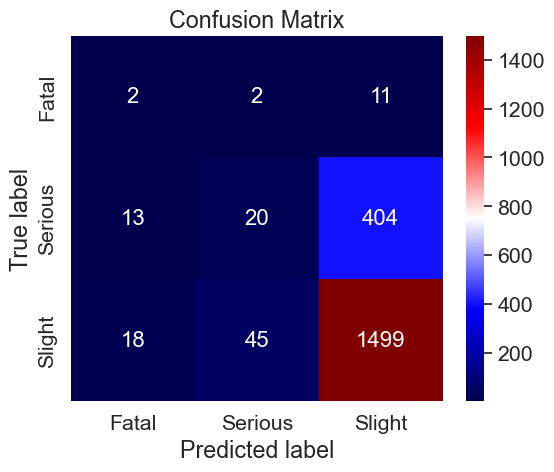

In [180]:
# Evaluate the best model on the test set
yhat_ada1 = best_adaboost_1.predict(Xtest)
p, r, f, s= precision_recall_fscore_support(y_test_new, yhat_ada1, average = 'weighted')
#print('Execution time of ADaBoost Hyperparameter Model is:',timedelta(seconds=timer() - start))
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
conf_mat(yhat_ada1, y_test_new)

#### Feature importance

engine_capacity_cc: 0.145
driver_imd_decile_2: 0.070
journey_purpose_of_driver_5: 0.060
age_of_driver: 0.060
sex_of_driver_2: 0.055
propulsion_code_2: 0.055
driver_imd_decile_8: 0.050
driver_imd_decile_4: 0.050
age_of_vehicle: 0.050
journey_purpose_of_driver_2: 0.045
driver_imd_decile_5: 0.040
driver_imd_decile_3: 0.040
driver_home_area_type_3: 0.040
driver_home_area_type_2: 0.040
driver_imd_decile_7: 0.035
driver_imd_decile_6: 0.035
driver_imd_decile_9: 0.020
driver_imd_decile_10: 0.020
vehicle_type_21: 0.015
vehicle_type_19: 0.015
towing_and_articulation_1: 0.015
vehicle_type_90: 0.010
vehicle_type_9: 0.010
vehicle_type_8: 0.005
vehicle_type_5: 0.005
vehicle_type_17: 0.005
vehicle_type_11: 0.005
journey_purpose_of_driver_3: 0.005
vehicle_type_4: 0.000
vehicle_type_3: 0.000
vehicle_type_20: 0.000
vehicle_type_2: 0.000
towing_and_articulation_9: 0.000
towing_and_articulation_5: 0.000
towing_and_articulation_4: 0.000
towing_and_articulation_3: 0.000
sex_of_driver_3: 0.000
propulsion_cod

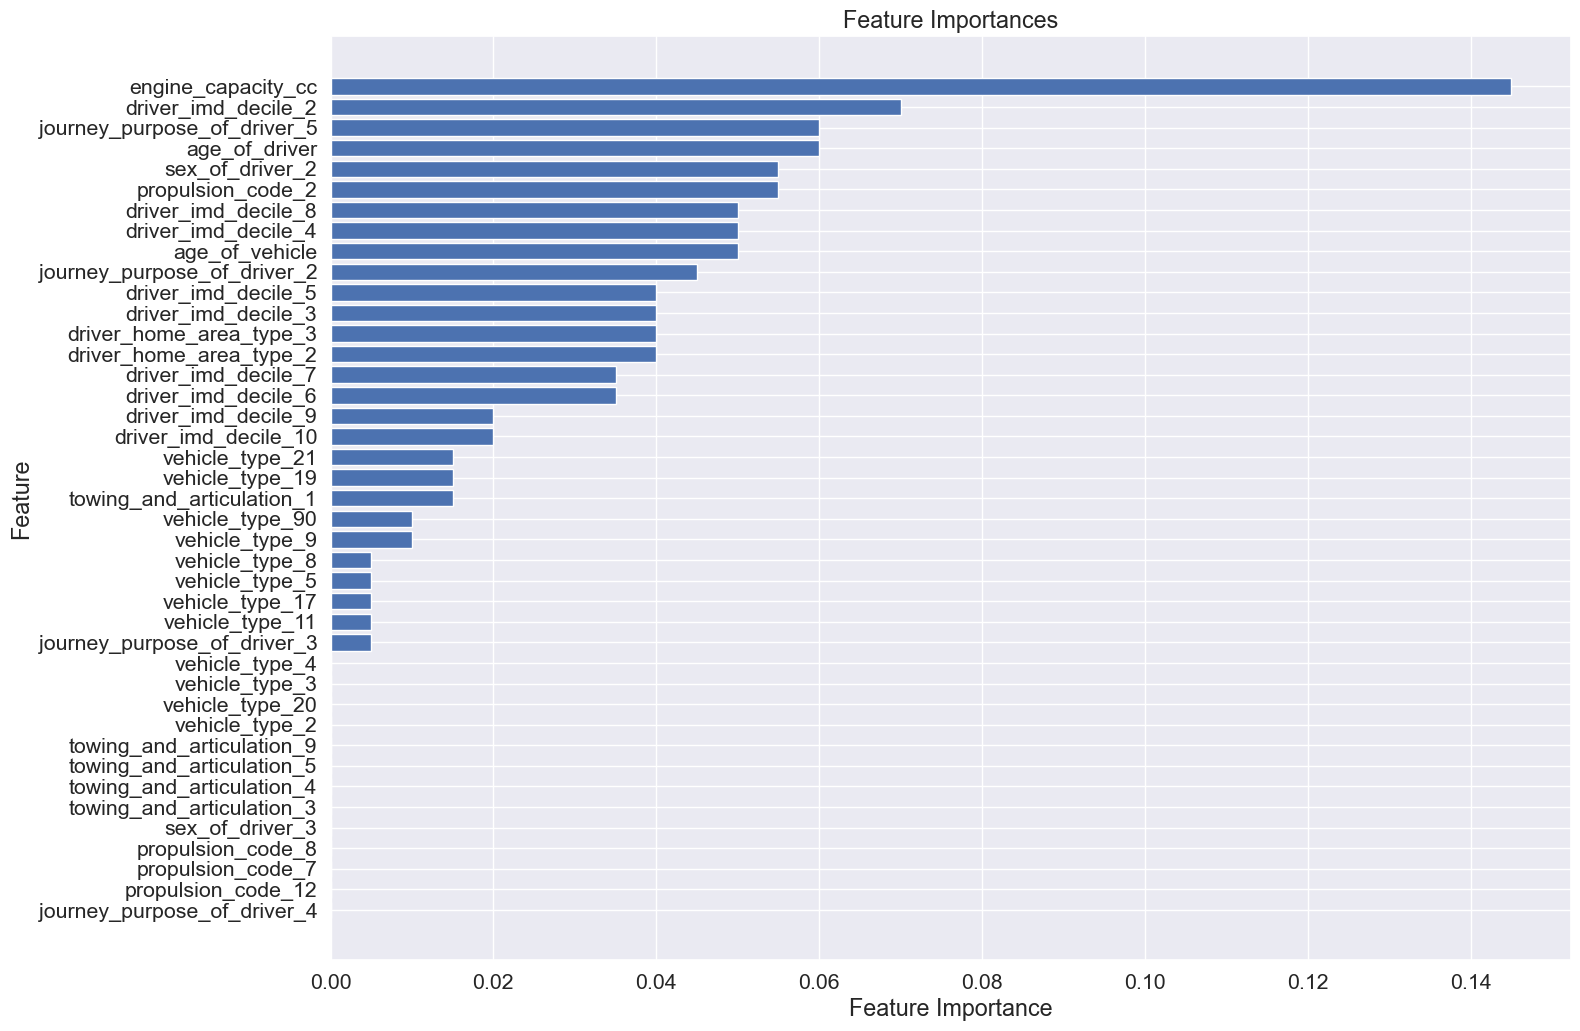

In [195]:
feature_importances = best_adaboost.feature_importances_
sorted_features = sorted(zip(feature_importances, X_train_resampled.columns), reverse=True)

# Print feature importances
for k, v in sorted_features:
    print(f"{v}: {k:.3f}")

# Create a bar plot for visualization
plt.figure(figsize=(16, 12))
plt.barh(range(len(sorted_features)), [x[0] for x in sorted_features], align='center')
plt.yticks(range(len(sorted_features)), [x[1] for x in sorted_features])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
plt.show()
    
    



Creating one new dataframe with removing least importance features

In [84]:
X_train_final= X_train_resampled.loc[:,
['engine_capacity_cc','driver_imd_decile_2','journey_purpose_of_driver_5','age_of_driver','sex_of_driver_2','propulsion_code_2','driver_imd_decile_8','propulsion_code_2','driver_imd_decile_8','driver_imd_decile_4','age_of_vehicle','journey_purpose_of_driver_2','driver_imd_decile_5','driver_imd_decile_3','driver_home_area_type_3','driver_home_area_type_2','driver_imd_decile_7','driver_imd_decile_6','driver_imd_decile_9','driver_imd_decile_10','vehicle_type_21','vehicle_type_19','towing_and_articulation_1','vehicle_type_90','vehicle_type_9','vehicle_type_8','vehicle_type_5','vehicle_type_17','vehicle_type_11','journey_purpose_of_driver_3']]
#Validating Features dataframe
X_train_final.shape

(18744, 30)

In [82]:
X_test_final= Xtest.loc[:,
['engine_capacity_cc','driver_imd_decile_2','journey_purpose_of_driver_5','age_of_driver','sex_of_driver_2','propulsion_code_2','driver_imd_decile_8','propulsion_code_2','driver_imd_decile_8','driver_imd_decile_4','age_of_vehicle','journey_purpose_of_driver_2','driver_imd_decile_5','driver_imd_decile_3','driver_home_area_type_3','driver_home_area_type_2','driver_imd_decile_7','driver_imd_decile_6','driver_imd_decile_9','driver_imd_decile_10','vehicle_type_21','vehicle_type_19','towing_and_articulation_1','vehicle_type_90','vehicle_type_9','vehicle_type_8','vehicle_type_5','vehicle_type_17','vehicle_type_11','journey_purpose_of_driver_3']]
#Validating Features dataframe
X_test_final.shape

(2014, 30)

As I have extracted some features based on feature importance, I applied gridsearch to find best parameters on this newly extracted trainset and validate the result.

In [89]:
weights = np.ones(len(y_train_encoded))
weights[y_train_encoded == 0] = 4  # Assign higher weight to "Fatal" class
weights[y_train_encoded == 1] = 1  # Assign higher weight to "Serious" class

start = time.time()
# Create AdaBoost classifier
adaboost_clf_1 = AdaBoostClassifier()

# # Train the classifier
# adaboost_clf_1.fit(X_train_resampled, y_train_encoded,sample_weight=weights)

# # Predict on the test set
# y_pred = adaboost_clf_1.predict(Xtest)

# p, r, f_ada_1, s= precision_recall_fscore_support(y_test_new, y_pred, average = 'weighted')
# Adaboost_duration = time.time()-start
# print(f'Execution time of AdaBoost Model is: {Adaboost_duration:.3f} seconds')
# print(f"Precision: {p:.3f}")
# print(f"Recall: {r:.3f}")
# print(f"F score: {f:.3f}")
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}
# Use GridSearchCV to search for the best hyperparameters
grid_searchADA_1 = GridSearchCV(adaboost_clf_1, param_grid, cv=5, scoring='f1_weighted', verbose=1)

grid_searchADA_1.fit(X_train_final, y_train_encoded,sample_weight=weights)

# Get the best model
best_adaboost_1 = grid_searchADA_1.best_estimator_



Fitting 5 folds for each of 18 candidates, totalling 90 fits


## Interpreting the best model performance

In [90]:
best_adaboost_1 = grid_searchADA_1.best_estimator_

Precision: 0.680
Recall: 0.754
F score: 0.693
Support score: None


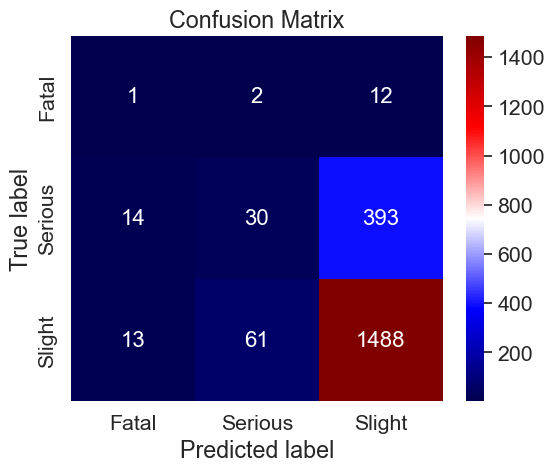

              precision    recall  f1-score   support

           0       0.04      0.07      0.05        15
           1       0.32      0.07      0.11       437
           2       0.79      0.95      0.86      1562

    accuracy                           0.75      2014
   macro avg       0.38      0.36      0.34      2014
weighted avg       0.68      0.75      0.69      2014



In [93]:
from sklearn.metrics import classification_report
yhat_ada = best_adaboost_1.predict(X_test_final)
p, r, f, s= precision_recall_fscore_support(y_test_new, yhat_ada, average = 'weighted')
#print('Execution time of ADaBoost Hyperparameter Model is:',timedelta(seconds=timer() - start))
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
print(f"Support score: {s}")
conf_mat(yhat_ada, y_test_new)
print(classification_report(y_test_new,yhat_ada))

From the confusion matrix, it can be seen that for each category, there are some instances correctly identified (True Positive), few instances incorrectly predicted (could be either False Positive or false negetive). In this section, I will calculate the metrics to be able to identify the issues within the model

<style>
  table {
    margin: auto;
    width: 100%; /* Adjust the width as needed */
  }
  td {
    text-align: left;
    padding: 8px; /* Adding padding for better readability */
  }
  th
  {
    text-align: left;
  }
</style>

<table>
   <tr><th>Accident_Severity</th><th>True Positive</th><th>False Positive</th><th>False Negetive</th></tr>
<tr><td>Fatal</td><td>1</td><td>27</td><td>14</td></tr>
<tr><td>Serious</td><td>30</td><td>63</td><td>407</td></tr>
<tr><td>Slight</td><td>1488</td><td>405</td><td>74</td></tr>

</table> 

For Fatal category
-  Precision: 1/(27+1)=0.04
-  Recall: 1/(1+14)=0.07
-  F1 Score: 2*0.04*0.07/(0.04+0.07) =0.05
    
For Serious category
-  Precision: 30/(30+63)=0.32
-  Recall: 30/(30+407)=0.07
-  F1 Score: 2 * 0.32* 0.07/(0.32+0.07)= 0.11

For Slight category
-  Precision: 1488/(1488+405)=0.79
-  Recall: 1488/(1488+74)=0.95
-  F1 Score: 2 * 0.79 * 0.95/(0.79+0.95)= 0.86


-  Here, I am using weighted average as in the pre-process section I applied SMOTE to make the it balanced. So, here I tried to take account of actual occurance of each classes.
 - My model is able to predict  1 fatal,30 serious,1488 slight true positive case based on driver's and vehicle history. 
-  Based on the prediction the insurance company will be able to predict the premium range based on severity. 
-  Though Road condition, Time, no of casualties these would helpful to better prediction,As a business analyst team from a   insurance company, these conditions will not be availabe at the time of predicting premium. 

Despite all these efforts, the F1 weighted score is still average.Some additional imprivements can be done to increase model performance:


Model Stacking: Instead of just using simple ensemble methods like AdaBoost and Random Forest, we can experiment with more sophisticated model stacking techniques.

Algorithm Tuning: Explore more advanced tuning strategies for your algorithms. For example, you can try more exhaustive grid search, explore different parameter ranges, or even consider Bayesian optimization for hyperparameter tuning.

Different Resampling Techniques: As This is a class imbalance problem where I applied SMOTE, we might experiment with other advance techniques such as Borderline-SMOTE, or SMOTE-ENN to see if they yield better results.

Model Interpretability: we can explore more complex models like gradient boosting machines (GBM), stacking, or neural networks.

Handling Outliers: More careful outlier handling technique should be applied.

Domain Knowledge: Leverage domain knowledge to engineer better features or to make informed decisions during preprocessing and model selection.

More historical data from past years and data Attributes such as:
Driving experience
Any past accidents history
Any drunk and driving case past history
this would help to predict more accurate result.